In [85]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
import gdown
import zipfile
import json
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.transforms.functional import to_pil_image
from torchvision.io import read_image 
import torchvision
import torch.nn as nn
import PIL
from sklearn.metrics import confusion_matrix, roc_curve, auc
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [86]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load dataset

In [4]:
def select_equal_samples(data, label_column='label'):
    """ Select equal # of pos/neg samples """
    positive_samples = data[data[label_column] == True]
    negative_samples = data[data[label_column] == False]

    # Determine the number of samples to select (minimum of positive and negative samples)
    num_samples = min(len(positive_samples), len(negative_samples))

    # Randomly select equal number of positive and negative samples without replacement
    selected_positive_samples = positive_samples.sample(n=num_samples, random_state=42, replace=False)
    selected_negative_samples = negative_samples.sample(n=num_samples, random_state=42, replace=False)

    # Concatenate the selected samples
    selected_samples = pd.concat([selected_positive_samples, selected_negative_samples])

    return selected_samples

In [5]:
class HOG_PedestrianClassificationDataset(Dataset):

    def __init__(self, labels_csv, root_dir, balance_labels=True, transform=None):
        self.labels = pd.read_csv(labels_csv)
        if balance_labels:
            self.labels = select_equal_samples(self.labels)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {True: 1, False: 0}
        # self.image_files = sorted(self.labels['image'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labels.iloc[idx]
        image_name = row['image'] + ".npy"
        image_name = os.path.join(self.root_dir, image_name) 
        image = np.load(image_name)
        image = image.reshape(image.shape[0], image.shape[1], -1) # flatten last 3 dimensions
        image = torch.from_numpy(image.transpose((2,0,1))).float()
        label = self.class_to_idx[row['label']]
        if self.transform:
            image = self.transform(image)
        return (image, label)

In [6]:
dataset = HOG_PedestrianClassificationDataset("./processed_labels.csv","./road-waymo/hog-fd/", balance_labels=True, transform = None)
print(f"Dataset len:  {len(dataset)}")

sample = dataset[5000]
print(sample[0].shape)
# to_pil_image(sample[0])

Dataset len:  5174
torch.Size([36, 23, 35])


In [7]:
# Split training and testing
train_ratio = 0.8
val_ratio = 0.1

dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Use random_split to split the dataset into training and testing sets.
torch.manual_seed(0)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [8]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [52]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 36, 23, 35])

# Experiments

In [10]:
num_epoch = 15 # TODO: change num_epoch to like 10 or 15 or something
def train(model, train_dataloader, val_dataloader, save_path):
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer =  torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_accuracy = 0.0
    val_error = []
    train_error = []
    
    for epoch in tqdm(range(num_epoch), desc="epochs"):  # loop over the dataset multiple times
        model.train()
        starttime = time()
        trainloss = 0
        for train_data in tqdm(train_dataloader, desc="training 1 epoch"):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = train_data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            trainloss += loss.cpu().item()
            optimizer.step()
            # break # TODO: delete this
        
        traintime = time() - starttime
        print(f"Epoch train time: {traintime}   Time per sample: {traintime / len(train_dataloader.dataset)}")
        train_error.append(trainloss / len(train_dataloader))
        
        # Validate
        valloss = 0
        correct = 0
        total = 0
        model.eval()
        all_predicted = torch.tensor([]).to(device)
        all_labels = torch.tensor([]).to(device)
        all_pred_probs = torch.tensor([]).to(device)
        with torch.no_grad():
            for images, labels in tqdm(val_dataloader, desc="Validating"):
                images = images.to(device)
                labels = labels.to(device)

                # calculate outputs by running images through the network
                outputs = model(images)
                valloss += criterion(outputs, labels).cpu().item()
                
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_predicted = torch.cat((all_predicted, predicted))
                all_labels = torch.cat((all_labels, labels))
                all_pred_probs = torch.cat((all_pred_probs, outputs.data))
                # break # TODO: delete this

        val_error.append(valloss / len(val_dataloader))
        
        conf_matrix = confusion_matrix(all_labels.cpu(), all_predicted.cpu())
        print("Val confusion matrix:")
        print(conf_matrix)
        print(f"{conf_matrix[0].sum().item()} frames don't have pedestrian, {conf_matrix[1].sum().item()} frames have pedestrian")
        
        tp = conf_matrix[0,0]
        fp = conf_matrix[1,0]
        fn = conf_matrix[0,1]
        print(f"TP: {tp}, FP: {fp}, FN: {fn}")
        print(f"Precision: {tp/(tp+fp)}, Recall: {tp/(tp+fn)}")

        accuracy = 100 * correct / total
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            print(f"Epoch {epoch}: Saving model to {save_path} with val accuracy {accuracy}%")
            torch.save(model.state_dict(), save_path)
    return train_error, val_error

In [212]:
# define model types
def resnet18_hog():
    model = torchvision.models.resnet18(weights = None)
    model.conv1 = torch.nn.Conv2d(2*2*9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
    return model

def linear_hog():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28980, 2, bias=True)
    )
    return model

class conv1_hog(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
        nn.Conv2d(9, 1, kernel_size=(16, 8)),
        nn.Flatten(),
        nn.Linear(1953,2)
        )
    def forward(self,x):
        x = x.view(-1,9,46,70)
        return self.model(x)

In [213]:
save_path = "./checkpoints/resnet18_HOG_fd_conv1"
model = conv1_hog()


model = torch.nn.DataParallel(model)
try:
    model.load_state_dict(torch.load(save_path))
    print("Successfully Loaded Saved Model")
except Exception as error:
    print("Failed to load Saved Model")
    print(error)
model.to(device)

Failed to load Saved Model
Error(s) in loading state_dict for DataParallel:
	size mismatch for module.model.2.weight: copying a param with shape torch.Size([2, 2553]) from checkpoint, the shape in current model is torch.Size([2, 1953]).


DataParallel(
  (module): conv1_hog(
    (model): Sequential(
      (0): Conv2d(9, 1, kernel_size=(16, 8), stride=(1, 1))
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Linear(in_features=1953, out_features=2, bias=True)
    )
  )
)

In [214]:
train_errors, val_errors = train(model, train_dataloader, val_dataloader, save_path)

training 1 epoch: 100%|████████████████████████| 65/65 [00:02<00:00, 22.24it/s]


Epoch train time: 2.938784122467041   Time per sample: 0.000710022740388268



epochs:   7%|██▎                                | 1/15 [00:03<00:46,  3.35s/it]

Val confusion matrix:
[[200  55]
 [ 58 204]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 200, FP: 58, FN: 55
Precision: 0.7751937984496124, Recall: 0.7843137254901961
Epoch 0: Saving model to ./checkpoints/resnet18_HOG_fd_conv1 with val accuracy 78.14313346228239%



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 19.07it/s]


Epoch train time: 3.408146858215332   Time per sample: 0.0008234227731856323



epochs:  13%|████▋                              | 2/15 [00:07<00:47,  3.62s/it]

Val confusion matrix:
[[207  48]
 [ 40 222]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 207, FP: 40, FN: 48
Precision: 0.8380566801619433, Recall: 0.8117647058823529
Epoch 1: Saving model to ./checkpoints/resnet18_HOG_fd_conv1 with val accuracy 82.97872340425532%



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 18.73it/s]


Epoch train time: 3.4699878692626953   Time per sample: 0.000838363824417177



epochs:  20%|███████                            | 3/15 [00:11<00:44,  3.74s/it]

Val confusion matrix:
[[235  20]
 [ 63 199]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 235, FP: 63, FN: 20
Precision: 0.7885906040268457, Recall: 0.9215686274509803
Epoch 2: Saving model to ./checkpoints/resnet18_HOG_fd_conv1 with val accuracy 83.9458413926499%



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 18.98it/s]


Epoch train time: 3.424079179763794   Time per sample: 0.0008272720898197134



epochs:  27%|█████████▎                         | 4/15 [00:14<00:41,  3.78s/it]

Val confusion matrix:
[[230  25]
 [ 51 211]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 230, FP: 51, FN: 25
Precision: 0.8185053380782918, Recall: 0.9019607843137255
Epoch 3: Saving model to ./checkpoints/resnet18_HOG_fd_conv1 with val accuracy 85.29980657640232%



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 18.99it/s]


Epoch train time: 3.423038959503174   Time per sample: 0.0008270207681814868



epochs:  33%|███████████▋                       | 5/15 [00:18<00:38,  3.80s/it]

Val confusion matrix:
[[232  23]
 [ 47 215]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 232, FP: 47, FN: 23
Precision: 0.8315412186379928, Recall: 0.9098039215686274
Epoch 4: Saving model to ./checkpoints/resnet18_HOG_fd_conv1 with val accuracy 86.46034816247582%



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 18.65it/s]


Epoch train time: 3.485600471496582   Time per sample: 0.0008421358955053351



epochs:  40%|██████████████                     | 6/15 [00:22<00:34,  3.83s/it]

Val confusion matrix:
[[221  34]
 [ 30 232]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 221, FP: 30, FN: 34
Precision: 0.8804780876494024, Recall: 0.8666666666666667
Epoch 5: Saving model to ./checkpoints/resnet18_HOG_fd_conv1 with val accuracy 87.62088974854932%



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 19.08it/s]


Epoch train time: 3.423002243041992   Time per sample: 0.0008270118973283383



epochs:  47%|████████████████▎                  | 7/15 [00:26<00:30,  3.82s/it]

Val confusion matrix:
[[226  29]
 [ 34 228]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 226, FP: 34, FN: 29
Precision: 0.8692307692307693, Recall: 0.8862745098039215
Epoch 6: Saving model to ./checkpoints/resnet18_HOG_fd_conv1 with val accuracy 87.81431334622825%



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 18.90it/s]


Epoch train time: 3.4391260147094727   Time per sample: 0.0008309074691252652



epochs:  53%|██████████████████▋                | 8/15 [00:30<00:26,  3.82s/it]

Val confusion matrix:
[[237  18]
 [ 46 216]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 237, FP: 46, FN: 18
Precision: 0.8374558303886925, Recall: 0.9294117647058824



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 18.82it/s]


Epoch train time: 3.453946828842163   Time per sample: 0.0008344882408413054



epochs:  60%|█████████████████████              | 9/15 [00:34<00:23,  3.84s/it]

Val confusion matrix:
[[246   9]
 [ 53 209]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 246, FP: 53, FN: 9
Precision: 0.822742474916388, Recall: 0.9647058823529412
Epoch 8: Saving model to ./checkpoints/resnet18_HOG_fd_conv1 with val accuracy 88.00773694390716%



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 19.07it/s]


Epoch train time: 3.408223867416382   Time per sample: 0.0008234413789360672



epochs:  67%|██████████████████████▋           | 10/15 [00:37<00:19,  3.82s/it]

Val confusion matrix:
[[235  20]
 [ 38 224]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 235, FP: 38, FN: 20
Precision: 0.8608058608058609, Recall: 0.9215686274509803
Epoch 9: Saving model to ./checkpoints/resnet18_HOG_fd_conv1 with val accuracy 88.78143133462282%



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 18.98it/s]


Epoch train time: 3.424274444580078   Time per sample: 0.0008273192666296396



epochs:  73%|████████████████████████▉         | 11/15 [00:41<00:15,  3.82s/it]

Val confusion matrix:
[[233  22]
 [ 26 236]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 233, FP: 26, FN: 22
Precision: 0.8996138996138996, Recall: 0.9137254901960784
Epoch 10: Saving model to ./checkpoints/resnet18_HOG_fd_conv1 with val accuracy 90.71566731141199%



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 18.99it/s]


Epoch train time: 3.43854022026062   Time per sample: 0.0008307659386954868



epochs:  80%|███████████████████████████▏      | 12/15 [00:45<00:11,  3.82s/it]

Val confusion matrix:
[[239  16]
 [ 31 231]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 239, FP: 31, FN: 16
Precision: 0.8851851851851852, Recall: 0.9372549019607843
Epoch 11: Saving model to ./checkpoints/resnet18_HOG_fd_conv1 with val accuracy 90.9090909090909%



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 18.82it/s]


Epoch train time: 3.4540390968322754   Time per sample: 0.0008345105331800617



epochs:  87%|█████████████████████████████▍    | 13/15 [00:49<00:07,  3.83s/it]

Val confusion matrix:
[[236  19]
 [ 25 237]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 236, FP: 25, FN: 19
Precision: 0.9042145593869731, Recall: 0.9254901960784314
Epoch 12: Saving model to ./checkpoints/resnet18_HOG_fd_conv1 with val accuracy 91.48936170212765%



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 19.08it/s]


Epoch train time: 3.4071292877197266   Time per sample: 0.0008231769238269453



epochs:  93%|███████████████████████████████▋  | 14/15 [00:53<00:03,  3.82s/it]

Val confusion matrix:
[[232  23]
 [ 22 240]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 232, FP: 22, FN: 23
Precision: 0.9133858267716536, Recall: 0.9098039215686274



training 1 epoch: 100%|████████████████████████| 65/65 [00:03<00:00, 19.08it/s]


Epoch train time: 3.422442674636841   Time per sample: 0.0008268767032222374



epochs: 100%|██████████████████████████████████| 15/15 [00:57<00:00,  3.80s/it]

Val confusion matrix:
[[228  27]
 [ 19 243]]
255 frames don't have pedestrian, 262 frames have pedestrian
TP: 228, FP: 19, FN: 27
Precision: 0.9230769230769231, Recall: 0.8941176470588236


In [215]:
def test(model, test_dataloader, save_path, test_type):
    starttime = time()
    correct = 0
    total = 0
    model.eval()
    all_predicted = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    all_pred_probs = torch.tensor([]).to(device)
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader, desc="testing"):
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted = torch.cat((all_predicted, predicted))
            all_labels = torch.cat((all_labels, labels))
            all_pred_probs = torch.cat((all_pred_probs, outputs.data))
            # break # TODO: remove this
    
    testtime = time() - starttime
    print(f"Total test time: {testtime}   Time per sample: {testtime / len(test_dataloader.dataset)}")
    # Let's say y_true is your true binary labels and y_pred_probs is the predicted probabilities for the positive class
    # You should replace them with your actual variables

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(all_labels.cpu(), all_pred_probs[:,1].cpu(), pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("ROC curve area:", roc_auc)

    # Plotting the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    conf_matrix = confusion_matrix(all_labels.cpu(), all_predicted.cpu())
    print(conf_matrix)
    print(f"{conf_matrix[0].sum().item()} frames don't have pedestrian, {conf_matrix[1].sum().item()} frames have pedestrian")
    tp = conf_matrix[0,0]
    fp = conf_matrix[1,0]
    fn = conf_matrix[0,1]
    print(f"TP: {tp}, FP: {fp}, FN: {fn}")
    print(f"Precision: {tp/(tp+fp)}, Recall: {tp/(tp+fn)}")
    accuracy = 100 * correct / total
    print(f"Accuracy for {save_path}: {accuracy}")
    plt.show()

Successfully Loaded Saved Model


testing: 100%|███████████████████████████████████| 9/9 [00:00<00:00, 19.89it/s]


Total test time: 0.4525728225708008   Time per sample: 0.0008736927076656386
ROC curve area: 0.9599772835963654
[[219  27]
 [ 24 248]]
246 frames don't have pedestrian, 272 frames have pedestrian
TP: 219, FP: 24, FN: 27
Precision: 0.9012345679012346, Recall: 0.8902439024390244
Accuracy for ./checkpoints/resnet18_HOG_fd_conv1: 90.15444015444015


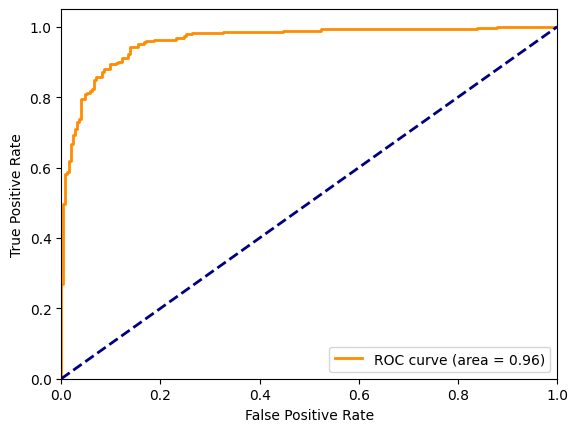

In [216]:
try:
    model.load_state_dict(torch.load(save_path))
    print("Successfully Loaded Saved Model")
except Exception as error:
    print("Failed to load Saved Model")
    print(error)
model.to(device)

test(model, test_dataloader, save_path, "HOG")

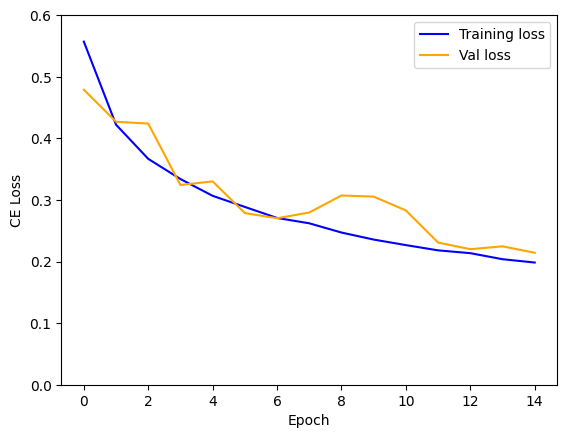

In [217]:
# Plot training curves
plt.plot(train_errors, label='Training loss', color='blue')
plt.plot(val_errors, label='Val loss',color='orange')
plt.ylabel("CE Loss")
plt.xlabel("Epoch")
plt.ylim([0,0.6])
plt.legend()

# Look at filters for conv1_hog

In [222]:
filters = model.module.model[0].weight.squeeze().cpu().detach()

In [223]:
# filters = torch.softmax(filters,0)

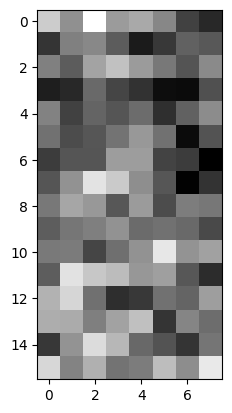

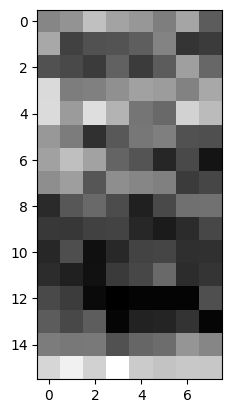

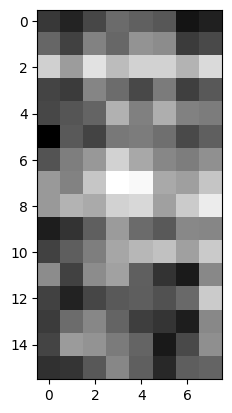

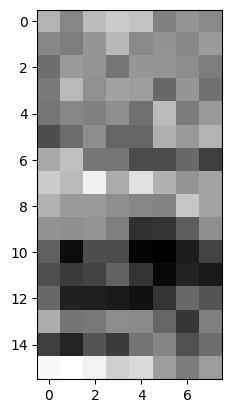

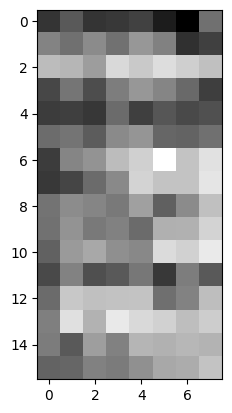

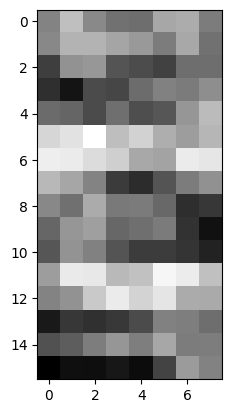

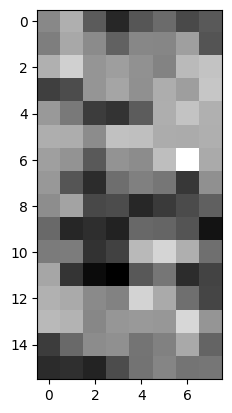

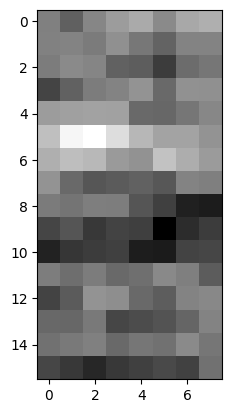

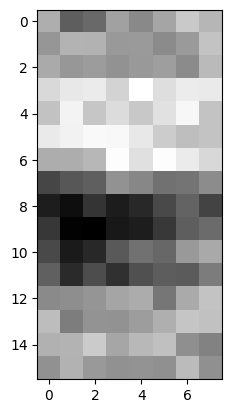

In [224]:
for filter in filters:
    plt.imshow(filter,cmap='gray')
    plt.show()

In [225]:
from skimage import draw
c_row=16
c_col=16
b_row, b_col = 2,2

orientation_histogram = filters.permute(1,2,0).cpu().numpy()

print(orientation_histogram.shape)

n_cells_row,n_cells_col,orientations = orientation_histogram.shape
s_row = c_row * n_cells_row
s_col = c_col * n_cells_col

radius = min(c_row, c_col) // 2 - 1
orientations_arr = np.arange(orientations)
# set dr_arr, dc_arr to correspond to midpoints of orientation bins
orientation_bin_midpoints = (
    np.pi * (orientations_arr + .5) / orientations)
dr_arr = radius * np.sin(orientation_bin_midpoints)
dc_arr = radius * np.cos(orientation_bin_midpoints)
hog_image = np.zeros((s_row, s_col), dtype=float)
for r in range(n_cells_row):
    for c in range(n_cells_col):
        for o, dr, dc in zip(orientations_arr, dr_arr, dc_arr):
            centre = tuple([r * c_row + c_row // 2,
                            c * c_col + c_col // 2])
            rr, cc = draw.line(int(centre[0] - dc),
                               int(centre[1] + dr),
                               int(centre[0] + dc),
                               int(centre[1] - dr))
            hog_image[rr, cc] += orientation_histogram[r, c, o]

(16, 8, 9)


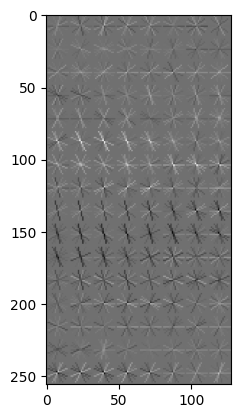

In [227]:
plt.imshow(hog_image, cmap='gray')